# GAN (Generative Adverserial Networks)
    In this notebook, a prototype for a GAN is created for the purpose of image data augmentation.

### Introduction to GAN

The GAN is consisted of a generator network and a discriminator network where the two networks compete with each other. While the generator producing counterfeit data from the given original data, the discriminator tries to distinguish the counterfeit version from the original version. As these two networks' competition repeats, we would have the generator keep getting better at producing higher quality of counterfeits, and we also would have the discriminator keep getting better at detecting counterfeit data. 

When we have a GAN successfully trained, we could theoretically augment the data that in its nature, it is hard to acquire in large quantity by utilizing the generator part of the GAN. 

This overview takes the codes from Chapter 8, Section 5 of Deep Learning with Python by Chollet. It includes 3 parts: the generator development, the discriminator development, and the adversarial network. Also for ease of implementation, the data used is some image data.

### The generator

The architecture of the generator in this example is pretty simple. According to Chollet, one of the most popular issues with GAN is that the generator gets studck with those images that look like noise. To prevent this from happening, we could use dropout on both the generator and the discriminator, which in this case we will set the droupout rate at 0.4.

In [20]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
# x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
# x = layers.Dropout(0.4)(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

### The discriminator

In [21]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

### The adversarial network

When setting up the GAN, we must set discriminator.trainable = False, because we are trying to train the generator to produce more "real" data that would make the discriminator guess the counterfeit version as "real." If we allow discriminator to be trainable, then the GAN would change the weights of discriminator to classify the data produced by generator as "real" regardless of whether input data is counterfeit or not. 

In [22]:
# Set discriminator weights to non-trainable
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Training DCGAN

DCGAN stands for deep convolutional generative adversarial network. The training of the DCGAN follows these steps:

    for each epoch:
        - pick a random point in the latent space
        - generate images with the generator by applying the random noise on the random point we just picked
        mix the generated images with the real ones
        - train the discriminator using the mixed images
        - pick a new randompoint in the latent space
        - train the GAN with random vectors, targeting to make this GAN to label all images as "real".
        
**important** 
The last line says to make all images real, it would update the weights of the generator not of the discriminator since we disabled the discriminator training. 

In [33]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]


# Show the image infomation
print("Number of images for training:", x_train.shape[0])
print("Number of images used for testing:", y_train.shape[0])
pix = int(np.sqrt(x_train.shape[1]))
print("Each image is:", pix, "by", pix, "pixels")

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

<class 'numpy.ndarray'>
Number of images for training: 5000
Number of images used for testing: 50000
Each image is: 5 by 5 pixels


In [24]:

iterations = 200
batch_size = 10
save_dir = os.getcwd()

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

Instructions for updating:
Use tf.cast instead.


/home/hj35/.local/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.69124806
adversarial loss at step 0: 0.62790394
discriminator loss at step 100: 0.6502948
adversarial loss at step 100: 2.2352483


### The results

The below is the images generated by the generator:

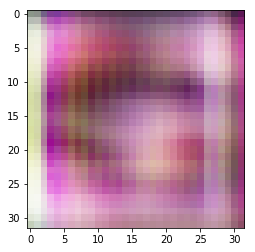

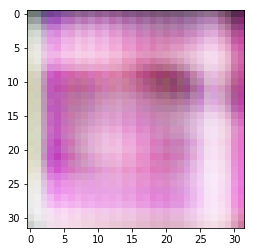

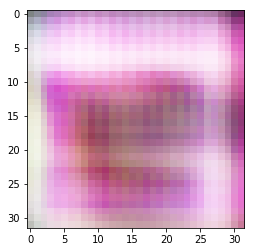

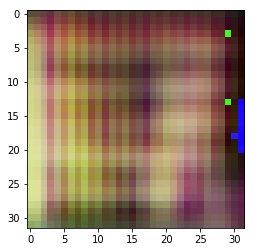

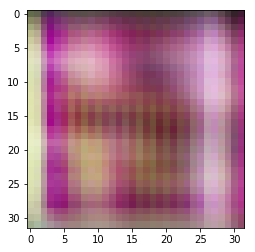

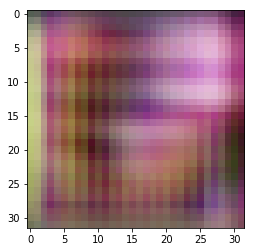

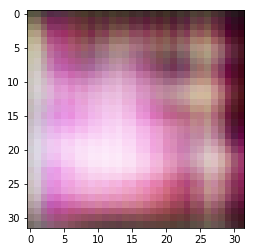

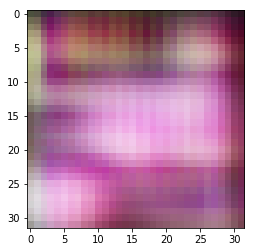

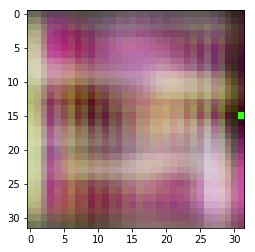

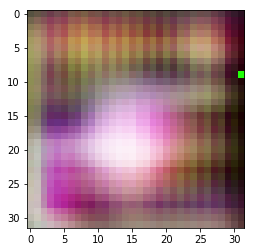

In [36]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

The above are the generated images which would resemble some pixallated images of frogs, if the training could run long enough iteration. The demonstration by Chollet was 100,000 iterations, as supposed to 200 iterations used in this example. Due to runtime duration, the iterations had to be reduced. (around 5 mins for each 100 iterations)

### Another Example: MNIST Dataset

Using the same GAN, a different dataset is fit. The dataset is taken from the famous MNIST hand-written digit images. Among all the digits, I chose "8" without any particular reason. The dimensions of the images are the same as the ones used in the frog dataset. Like before, the images needed some adjustments via reshaping. 

In [62]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (_, _) = mnist.load_data()

# Select number images (class 8)
x_train = x_train[y_train.flatten() == 8]
print(x_train.shape[0])

# Show the image infomation
print("Number of images for training:", x_train.shape[0])
print("Number of images used for testing:", x_train.shape[0])
pix = int(np.sqrt(x_train.shape[1]))
print("Each image is:", pix, "by", pix, "pixels")

# Adjustment for images
# train_images = train_images.resize(train_images.shape[0], 32, 32, 3)

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (28, 28, 1)).astype('float32') / 255.


5851
Number of images for training: 5851
Number of images used for testing: 5851
Each image is: 5 by 5 pixels


### The Generator

In [67]:
latent_dim = 28
height = 28
width = 28
channels = 1

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 14 * 14)(generator_input)
# x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((14, 14, 128))(x)
# x = layers.Dropout(0.4)(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25088)             727552    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 25088)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 256)       819456    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 256)       1048832   
__________

### The Discriminator

In [68]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 128)       262272    
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 5, 128)         262272    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 5, 5, 128)         0         
__________

### The Adverserial Network

In [69]:
# Set discriminator weights to non-trainable
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Training GAN

In [70]:

iterations = 200
batch_size = 10
save_dir = os.getcwd()

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

discriminator loss at step 0: 0.6862373
adversarial loss at step 0: 0.6158816
discriminator loss at step 100: 0.022715874
adversarial loss at step 100: 6.8267794


### The Results

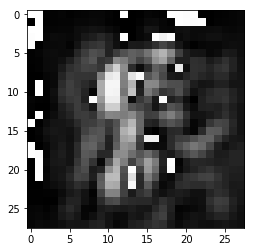

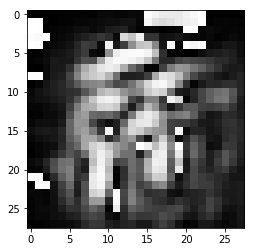

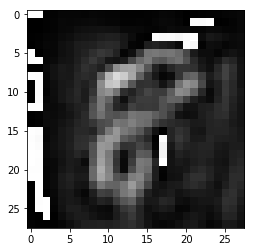

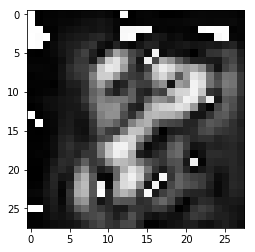

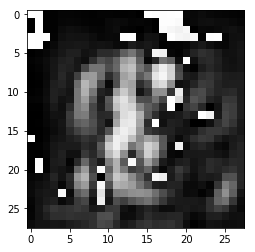

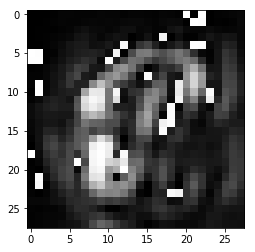

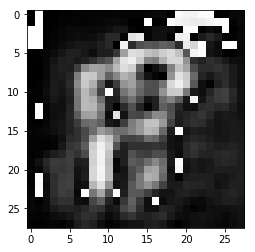

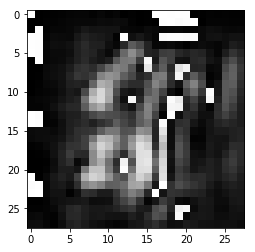

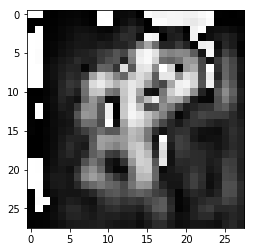

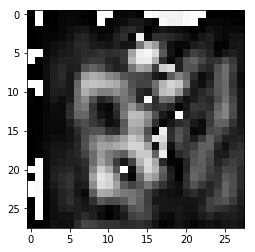

In [72]:
# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img, cmap = 'gray')
    
plt.show()

### Closing remarks

The GAN generated in this overview has a functioning GAN created by Chollet. There are some problems of runtime with the GAN training, which consumes too much time. Also, The each chunk of codes need to be wrapped into a function, which would be called at the last set of codes that would serve as main(). 